# 1. Calibrate the Camera

Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [1]:
# import modules for this project
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
import glob

# Read in and make a list of calibration chessboard images 
chessboard_images = glob.glob('./camera_cal/calibration*.jpg') # Chessboard images
test_images = glob.glob('./test_images/*.jpg')  # Test images

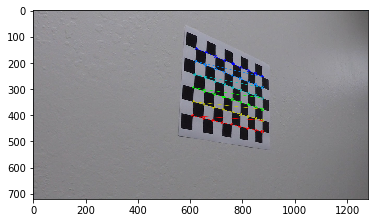

In [3]:
# Arrays to store object points and image points from all the images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prepare object points, like (0, 0, 0), (1, 0, 0) ..., (8, 5, 0)
objp = np.zeros((6*9, 3), np.float32)
# Generate the x and y coordinates and shape them into two columns
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) 

for fname in chessboard_images:
    # read in each image
    img = mpimg.imread(fname)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If coners are found, add object points, image points
    if ret == True:
        
        imgpoints.append(corners)
        objpoints.append(objp)

        # draw detected corners on the chessboard image and store it 
        name = './output_images/draw_corners/' + fname.split('/')[-1]
        img_draw = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img_draw)
        plt.savefig(name)
        
cv2.destroyAllWindows()

In [4]:
# Save the objpoints and imgpoints arrays
np.save('./output_images/imgpoints.npy', imgpoints)
np.save('./output_images/objpoints.npy', objpoints)

# 2. Correct for Image Distortion

Apply a distortion correction to raw images.

In [5]:
def cal_undistort(img):
    """
    The function performs the camera calibration
    and images distortion correction, 
    returns the undistorted image. 
    [img] a distorted 2D image
    [objpoints] the coordinates of the corners in undistorted 3D images
    [imgpoints] the coordinates of the corners in distorted 2D images.
    """
    # Load objpoints and imgpoints
    imgpoints = np.load('./output_images/imgpoints.npy')
    objpoints = np.load('./output_images/objpoints.npy')
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Find the camera matrix and distortion coefficients to transform 3D image points to 2D image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    # Undistort the input image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undist    

In [6]:
img_chessboard = mpimg.imread('./camera_cal/calibration3.jpg')
img_lane = mpimg.imread(test_images[0])

In [7]:
undistorted1 = cal_undistort(img_chessboard)
undistorted2 = cal_undistort(img_lane)

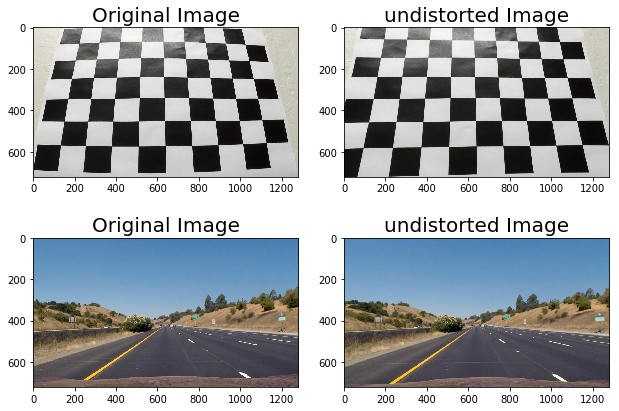

In [8]:
f, arr = plt.subplots(2, 2, figsize=(8, 6))
f.tight_layout()
arr[0,0].set_title('Original Image', fontsize=20)
arr[0,0].imshow(img_chessboard)
arr[1,0].set_title('Original Image', fontsize=20)
arr[1,0].imshow(img_lane)
arr[0,1].set_title('undistorted Image', fontsize=20)
arr[0,1].imshow(undistorted1)
arr[1,1].set_title('undistorted Image', fontsize=20)
arr[1,1].imshow(undistorted2)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('./output_images/undistorted_test.jpg')

# 3. Implement a Color & Gradient Threshold

Use color transform, gradients, etc., to create a threshold binary image.

__Note__: Make sure you use the correct grayscale conversion depending on how you've read in your images. Use `cv2.COLOR_RGB2GRAY` if you've read in an image using `mpimg.imread()`. Use `cv2.COLOR_BGR2GRAY` if you've read in an image using `cv2.imread()`.

## 3.1 Load and display original test images

Those test images are used to:
- check my threshold functions 
- tune and get the best parameter values for my threshold functions

In [9]:
# load all test images
images= []
names = []
for fname in test_images:
    # load and append test image
    img = mpimg.imread(fname)
    images.append(img)
    # pick image name out of file path
    name = fname.split('/')[-1].split('.')[0]
    names.append(name)

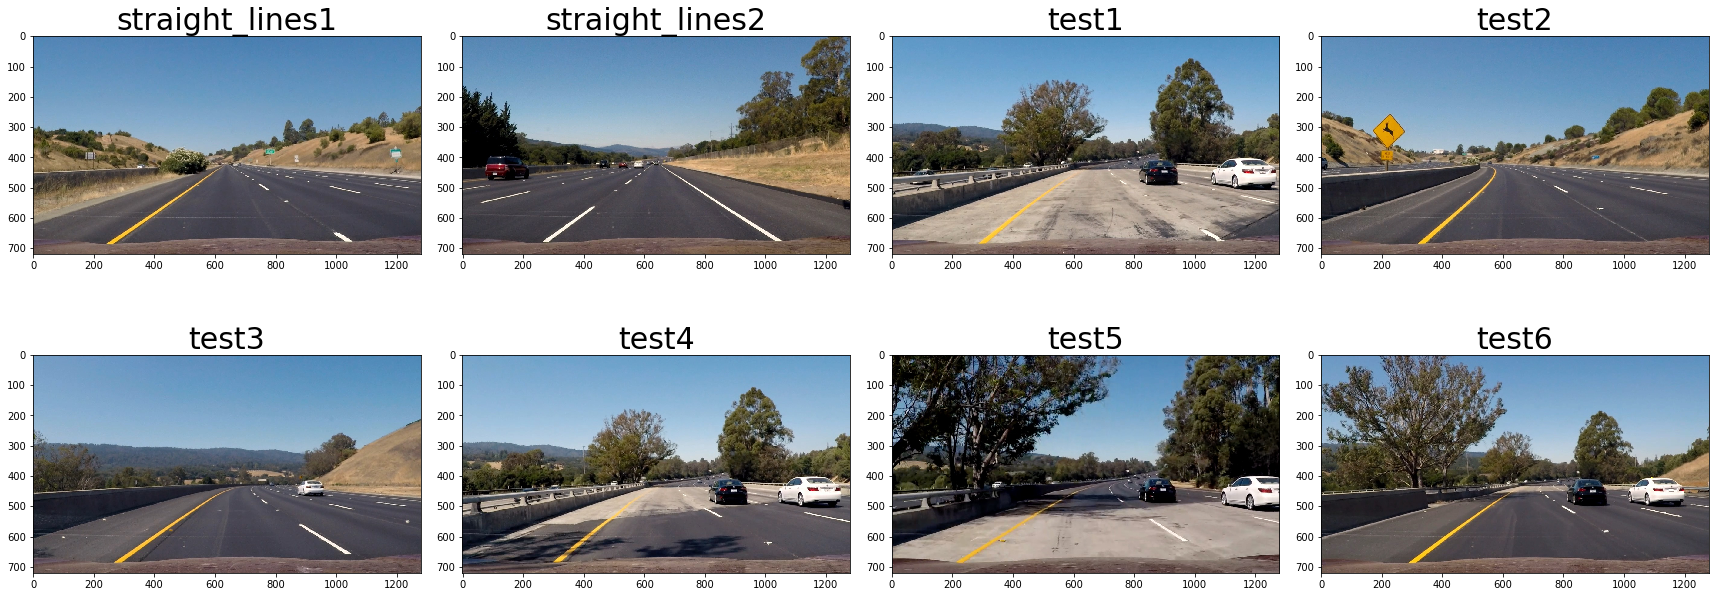

In [10]:
f, arr = plt.subplots(2,4, figsize=(24, 9))
f.tight_layout()
for i in range(len(images)):
    r = i//4  # row of image
    c = i - r*4  # colomn of image
    arr[r,c].imshow(images[i], cmap='gray')
    arr[r,c].set_title(names[i], fontsize=30)
plt.savefig('./output_images/thresholds/load_images.jpg')

## 3.2 HLS threshold

As to color space, HLS can be more robust than RGB. Here I'll read in the same original image (straight lines1), convert to sparated H,L and S channels to get the following results:

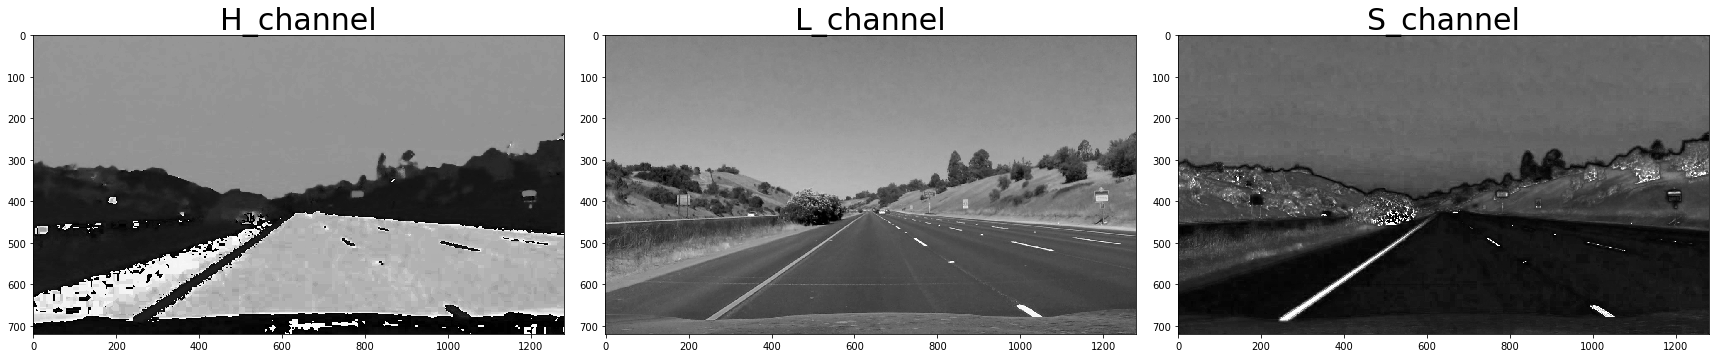

In [11]:
hls_0 = cv2.cvtColor(img_lane, cv2.COLOR_RGB2HLS)
H_0 = hls_0[:,:,0]
L_0 = hls_0[:,:,1]
S_0 = hls_0[:,:,2]

f, arr = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
arr[0].set_title('H_channel', fontsize=30)
arr[0].imshow(H_0, cmap='gray')
arr[1].set_title('L_channel', fontsize=30)
arr[1].imshow(L_0, cmap='gray')
arr[2].set_title('S_channel', fontsize=30)
arr[2].imshow(S_0, cmap='gray')

plt.savefig('./output_images/thresholds/HLS_compare.jpg')

The S channel picks up the lines well, so I'll apply a threshold on it.

In [12]:
def hls_select(img, thresh=(0, 255)):
    """
    The fucntion applies threshold on the S-channel of HLS.
    """
    # Select the S channel as it picks up the lines well
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2] 
    # Apply a threshold on S channel
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    
    return binary_output

I tune the parameter as `hls_select(img, thresh=(180, 255))`

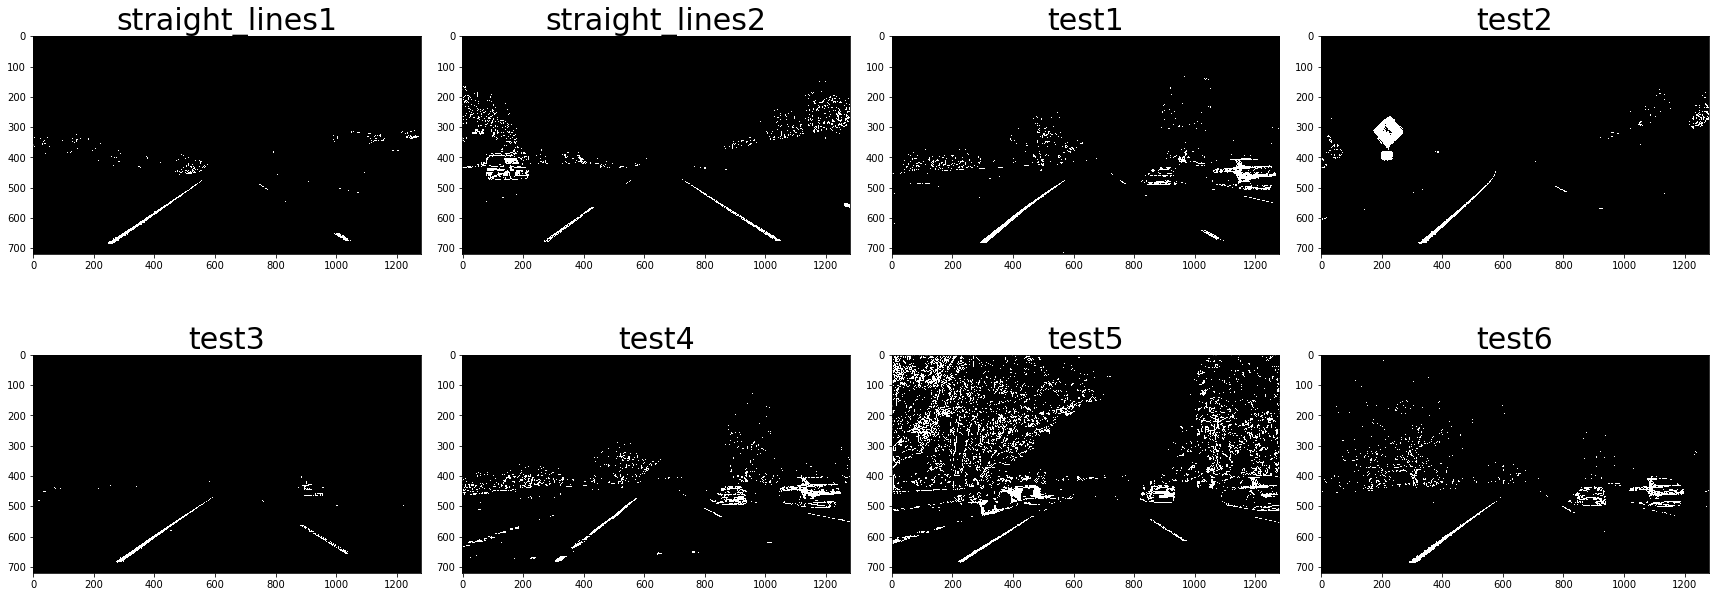

In [13]:
# Test function and tune parameters to get ideal output
f, arr = plt.subplots(2,4, figsize=(24, 9))
f.tight_layout()
for i in range(len(images)):
    binary_output = hls_select(images[i], thresh=(180, 255))
    r = i//4  # row of image 
    c = i - r*4  # colomn of image
    arr[r,c].imshow(binary_output, cmap='gray')
    arr[r,c].set_title(names[i], fontsize=30)
plt.savefig('./output_images/thresholds/HLS.jpg')

## 3.3 Gradient Threshold
### 3.3.1 Absolute Value of the Gradient

In [14]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    """
    The function applies Sobel x and y,
    then takes an absolute value and applies a threshold.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate directional gradient
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    elif orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Apply threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return binary_output

I tune the parameter as `abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)`

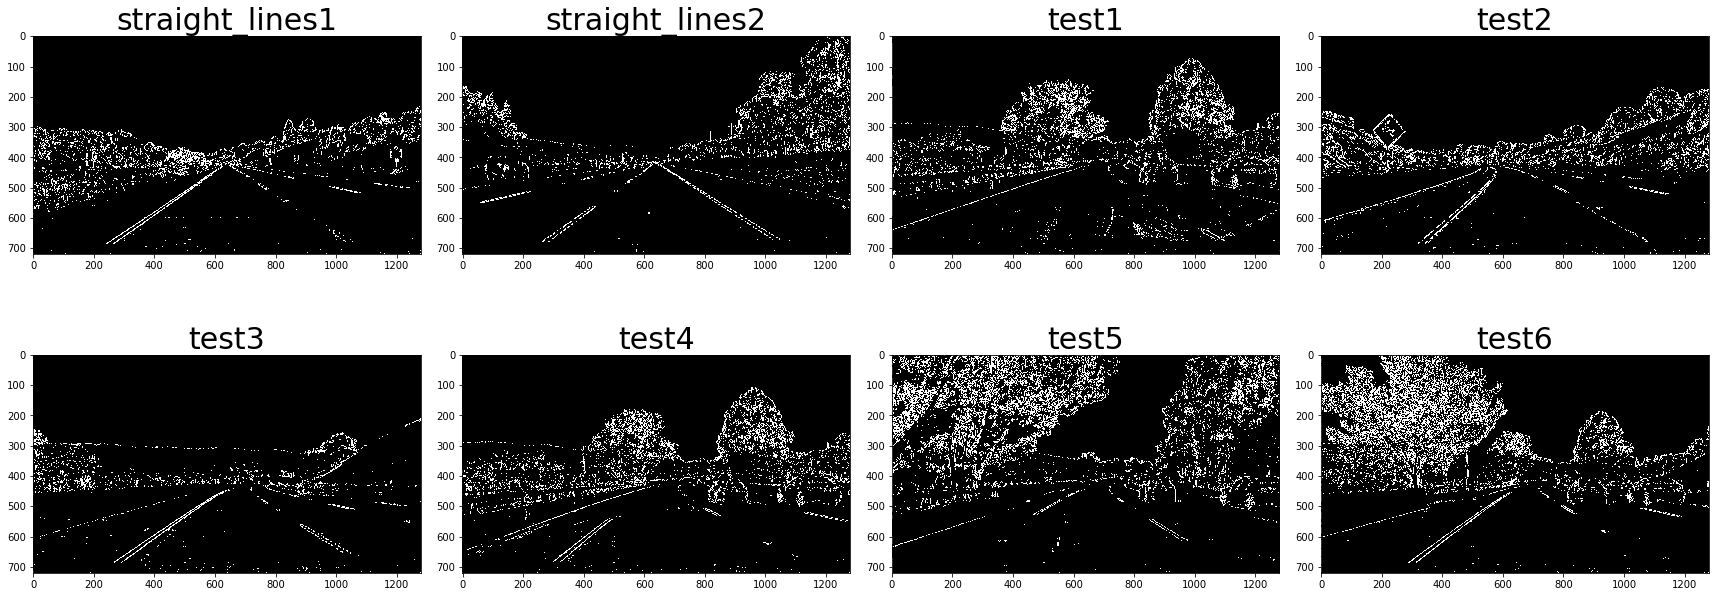

In [15]:
# Test function and tune parameters to get ideal output
f, arr = plt.subplots(2,4, figsize=(24, 9))
f.tight_layout()
for i in range(len(images)):
    binary_output_i = abs_sobel_thresh(images[i], orient='x', thresh_min=20, thresh_max=100)
    r = i//4  # row of image 
    c = i - r*4  # colomn of image
    arr[r,c].imshow(binary_output_i, cmap='gray')
    arr[r,c].set_title(names[i], fontsize=30)
plt.savefig('./output_images/thresholds/abs_sobel_thresh.jpg')

### 3.3.2 Magnitude of the Gradient

In [16]:
def mag_thresh(img, sobel_kernel, mag_thresh=(0, 255)):
    """
    The function returns the magnitude of the gradient
    for a given sobel kernel size and threshold values.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate gardient magnitude
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2, sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)   
    # Apply threshold
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return binary_output

I tune the parameter as `mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100))`

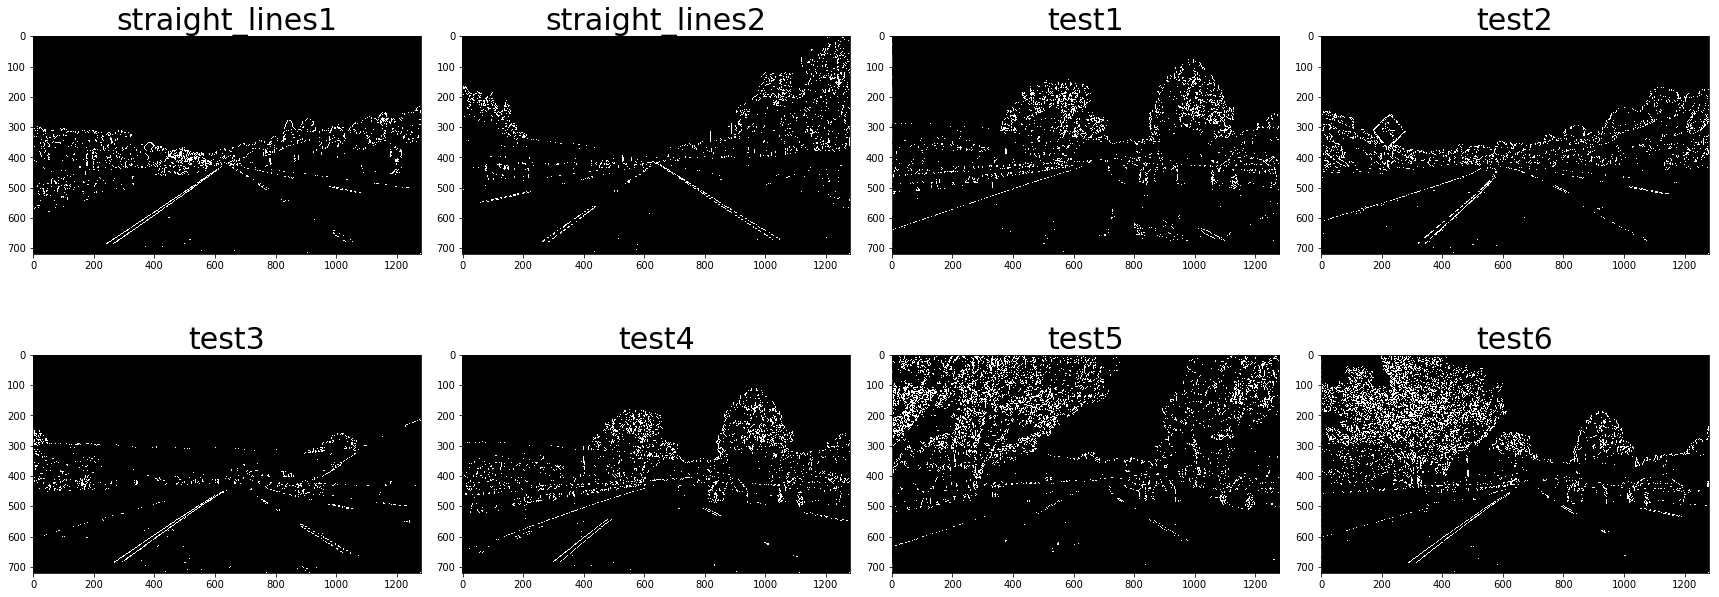

In [17]:
# Test function and tune parameters to get ideal output
f, arr = plt.subplots(2,4, figsize=(24, 9))
f.tight_layout()
for i in range(len(images)):
    binary_output = mag_thresh(images[i], sobel_kernel=3, mag_thresh=(30, 100))
    r = i//4  # row of image 
    c = i - r*4  # colomn of image
    arr[r,c].imshow(binary_output, cmap='gray')
    arr[r,c].set_title(names[i], fontsize=30)
plt.savefig('./output_images/thresholds/mag_thresh.jpg')

### 3.3.3 Direction of the Gradient

In [18]:
def dir_threshold(img, sobel_kernel, thresh=(0, np.pi/2)):
    """
    The function applies Sobel x and y, then compute the
    direction of the gradient and applies a threshold.
    """
    #gray = hls_select(img, thresh=(90, 255))
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate gradient direction
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # Apply threshold
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    return binary_output

I tune the parameter as `dir_threshold(img, sobel_kernel=9, thresh=(0.7, 1.2))`

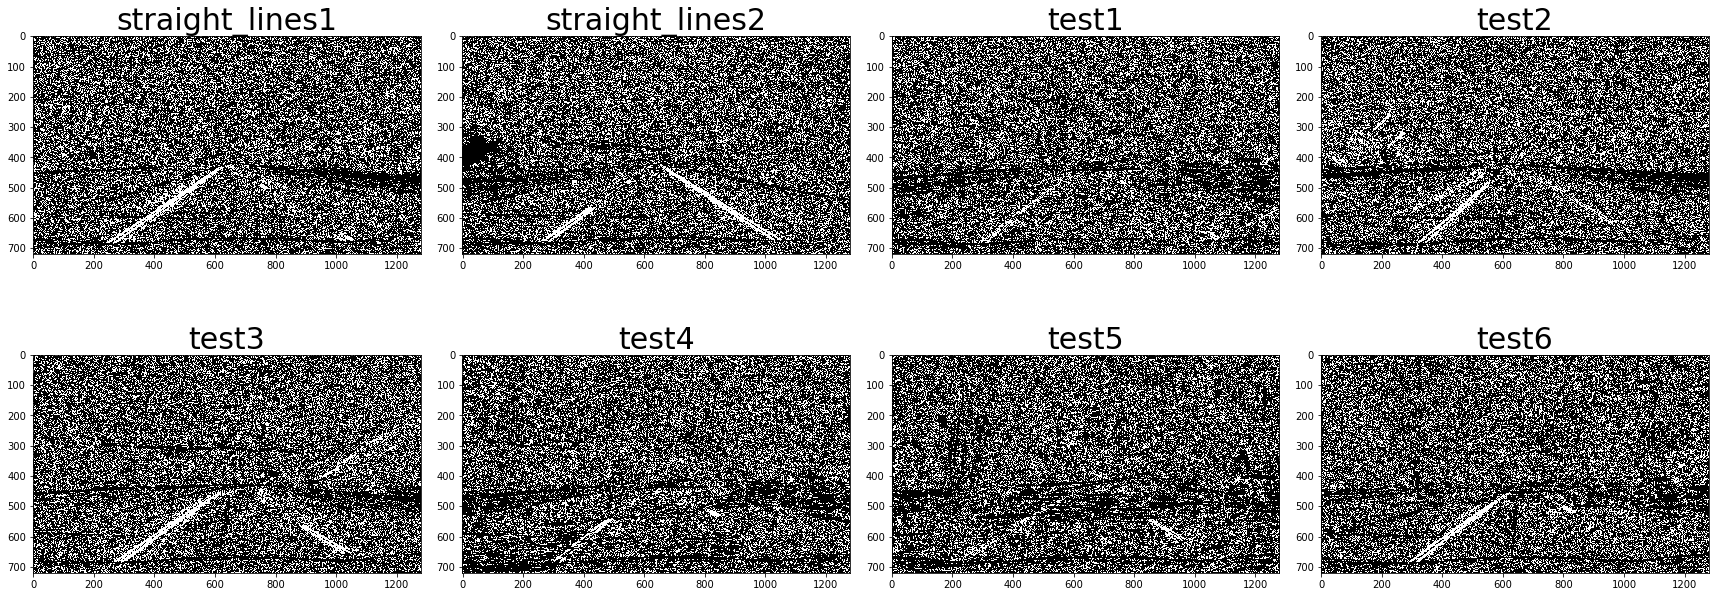

In [19]:
# Test function and tune parameters to get ideal output
f, arr = plt.subplots(2,4, figsize=(24, 9))
f.tight_layout()
for i in range(len(images)):
    binary_output = dir_threshold(images[i], sobel_kernel=9, thresh=(0.7, 1.2))
    r = i//4  # row of image 
    c = i - r*4  # colomn of image
    arr[r,c].imshow(binary_output, cmap='gray')
    arr[r,c].set_title(names[i], fontsize=30)
plt.savefig('./output_images/thresholds/dir_threshold.jpg')

### 3.3.4 Combing Gradient Thresholds

To summarize, I tune all threshold parameters as below:
- `hls_select(img, thresh=(180, 255))`
- `abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)`
- `mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100))`
- `dir_threshold(img, sobel_kernel=9, thresh=(0.7, 1.2))`

In [20]:
def combine_gradient(img):
    """
    The function combines gradient, magnitude of gradient and 
    direction of gradient thresholds.
    """
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)
    grady = abs_sobel_thresh(img, orient='y', thresh_min=20, thresh_max=100)
    mag_binary =  mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=9, thresh=(0.7, 1.2))

    combined = np.zeros_like(dir_binary)
    combined[((gradx==1) & (grady==1)) | ((mag_binary==1) & (dir_binary==1))] = 1
    
    return combined

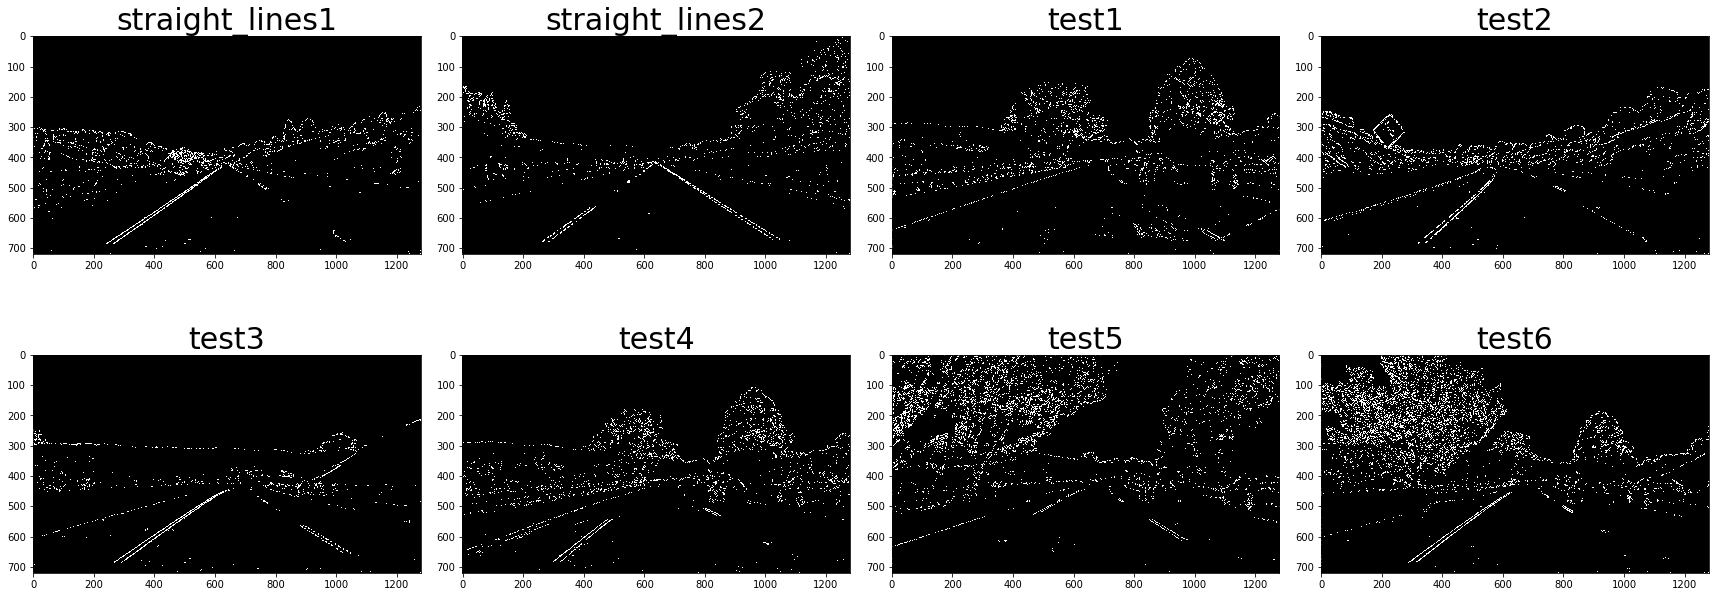

In [21]:
# Test function
f, arr = plt.subplots(2,4, figsize=(24, 9))
f.tight_layout()
for i in range(len(images)):
    binary_output = combine_gradient(images[i])
    r = i//4  # row of image 
    c = i - r*4  # colomn of image
    arr[r,c].imshow(binary_output, cmap='gray')
    arr[r,c].set_title(names[i], fontsize=30)
plt.savefig('./output_images/thresholds/combine_gradient.jpg')

## 3.4 Combining Color and Gradient Thresholds

In [22]:
def color_grad(img):
    """
    The function combines HLS color threshold and multiple gradient thresholds.
    """
    color_binary = hls_select(img, thresh=(180, 255))
    gradient_binary = combine_gradient(img)
    combined_binary = np.zeros_like(color_binary)
    combined_binary[(color_binary == 1) | (gradient_binary == 1)] = 1
    
    return combined_binary

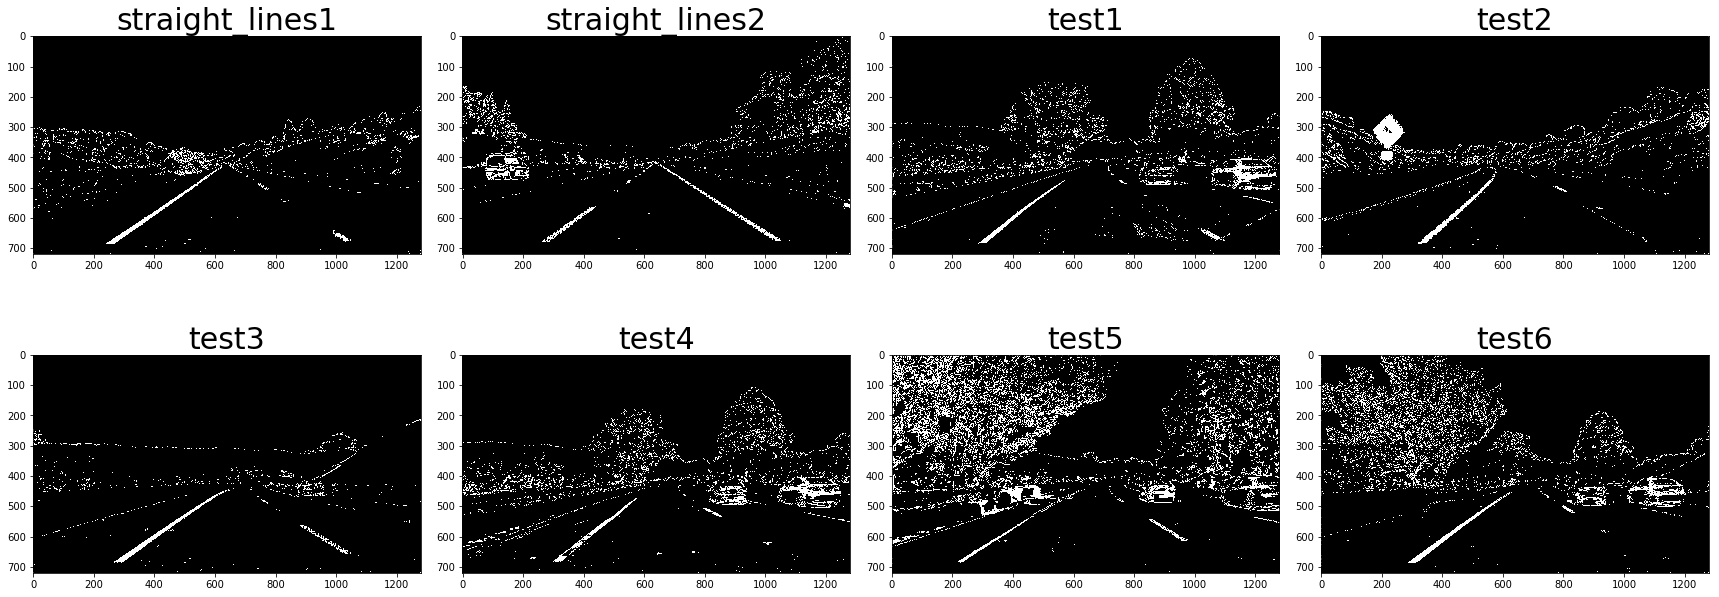

In [23]:
# Test function
f, arr = plt.subplots(2,4, figsize=(24, 9))
f.tight_layout()
for i in range(len(images)):
    binary_output = color_grad(images[i])
    r = i//4  # row of image 
    c = i - r*4  # colomn of image
    arr[r,c].imshow(binary_output, cmap='gray')
    arr[r,c].set_title(names[i], fontsize=30)
plt.savefig('./output_images/thresholds/color_grad.jpg')

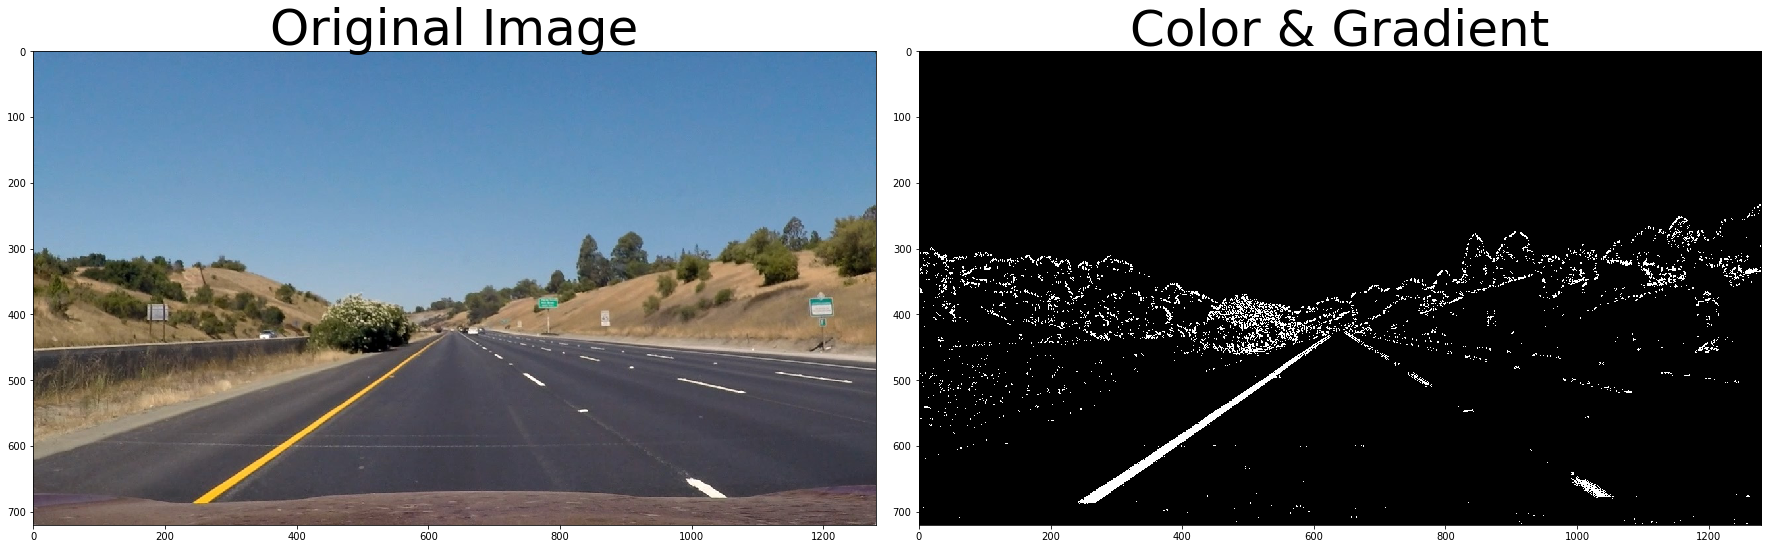

In [24]:
# Run the function
combine_binary = color_grad(img_lane)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_lane)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combine_binary, cmap='gray')
ax2.set_title('Color & Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('./output_images/thresholds/thresholds.jpg')

# 4. Warp the Image Using Perspective Transform

Apply a perspective transform to rectify binary image("birds-eye view").

## 4.1 Choose Source and Destination Points

In [25]:
img_size = (1280, 720) 

src = np.int32(
    [[(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 65), img_size[1] / 2 + 100],
    [(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]]])
dst = np.int32(
    [[(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0],
    [(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]]])

In [26]:
src

array([[1126,  720],
       [ 705,  460],
       [ 580,  460],
       [ 203,  720]], dtype=int32)

In [27]:
dst

array([[960, 720],
       [960,   0],
       [320,   0],
       [320, 720]], dtype=int32)

Apply the source (original) coordinates `src` and destination (desired  or warped) coordinates `dst` above in the following `warper` function.

In [28]:
def warper(img):
    """
    Define caliation box in source (original)
    and destination (desired or warped) coordinates. 
    """
    img_size = (img.shape[1], img.shape[0])
    # Four source coordinates
    src = np.float32([[1126,  720],
                      [ 705,  460],
                      [ 580,  460],
                      [ 203,  720]])
    # Four desired coordinates
    dst = np.float32([[960, 720],
                      [960,   0],
                      [320,   0],
                      [320, 720]])
    # Compute the perspective transform M
    M = cv2.getPerspectiveTransform(src, dst)
    # Compute the inverse perspective transform Minv
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Create warped image - uses linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv

## 4.2 Verify Source and Destination Points

I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto two test images with straight lines and their warped counterparts respectively to verify that the lines appear parallel in their corresponding warped image.

In [29]:
# Read test images with straight lines
straight_lines1 = mpimg.imread('./test_images/straight_lines1.jpg')
straight_lines2 = mpimg.imread('./test_images/straight_lines2.jpg')

# Undistort the images
undist_sl1 = cal_undistort(straight_lines1)
undist_sl2 = cal_undistort(straight_lines2)

# Warp the undistorted images
warp_sl1, _, _ = warper(undist_sl1)
warp_sl2, _, _ = warper(undist_sl2)

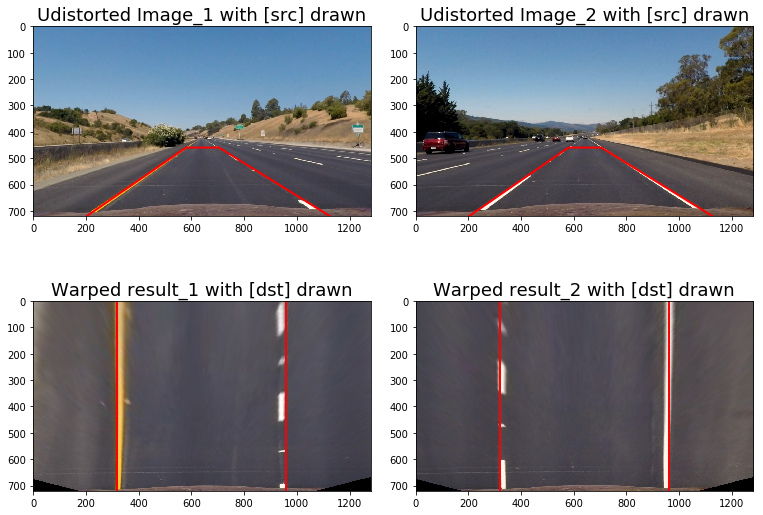

In [30]:
# Run the function
combine_binary = color_grad(img_lane)
# Plot the result
f, arr = plt.subplots(2, 2, figsize=(10, 8))
f.tight_layout()

arr[0,0].imshow(undist_sl1, extent=(0,1280,720,0))
arr[0,0].plot([1126,  705,  580,  203],
              [ 720,  460,  460,  720],'r-',linewidth=2)
arr[0,0].set_title('Udistorted Image_1 with [src] drawn', fontsize=18)

arr[0,1].imshow(undist_sl2, extent=(0,1280,720,0))
arr[0,1].plot([1126,  705,  580,  203],
              [ 720,  460,  460,  720],'r-',linewidth=2)
arr[0,1].set_title('Udistorted Image_2 with [src] drawn', fontsize=18)

arr[1,0].imshow(warp_sl1, cmap='gray', extent=(0,1280,720,0))
arr[1,0].plot([320, 320], [  0, 720],'r-',linewidth=2)
arr[1,0].plot([960, 960], [  0, 720],'r-',linewidth=2)
arr[1,0].set_title('Warped result_1 with [dst] drawn', fontsize=18)

arr[1,1].imshow(warp_sl2, cmap='gray', extent=(0,1280,720,0))
arr[1,1].plot([320, 320], [  0, 720],'r-',linewidth=2)
arr[1,1].plot([960, 960], [  0, 720],'r-',linewidth=2)
arr[1,1].set_title('Warped result_2 with [dst] drawn', fontsize=18)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('./output_images/src&dst_drawn.jpg')

## 4.3 Warp a Binary Image

I pick up all undistortion, threshold and warper function together to get a function `warp_camera(img_camera)` which take a original distorted image as input and output undistorted and warped binary image in bird-eye perspection.

In [31]:
def warp_camera(img_camera):
    """
    The input is the original image taken by camera.
    The function undistort the original image, apply a color&gradient threshold
    on the undistorted image and warp the binary image in bird-eye perspection.
    """
    img_undistort = cal_undistort(img_camera)
    img_threshold = color_grad(img_undistort)
    img_warped, M, Minv = warper(img_threshold)
    return img_undistort, img_warped, M, Minv

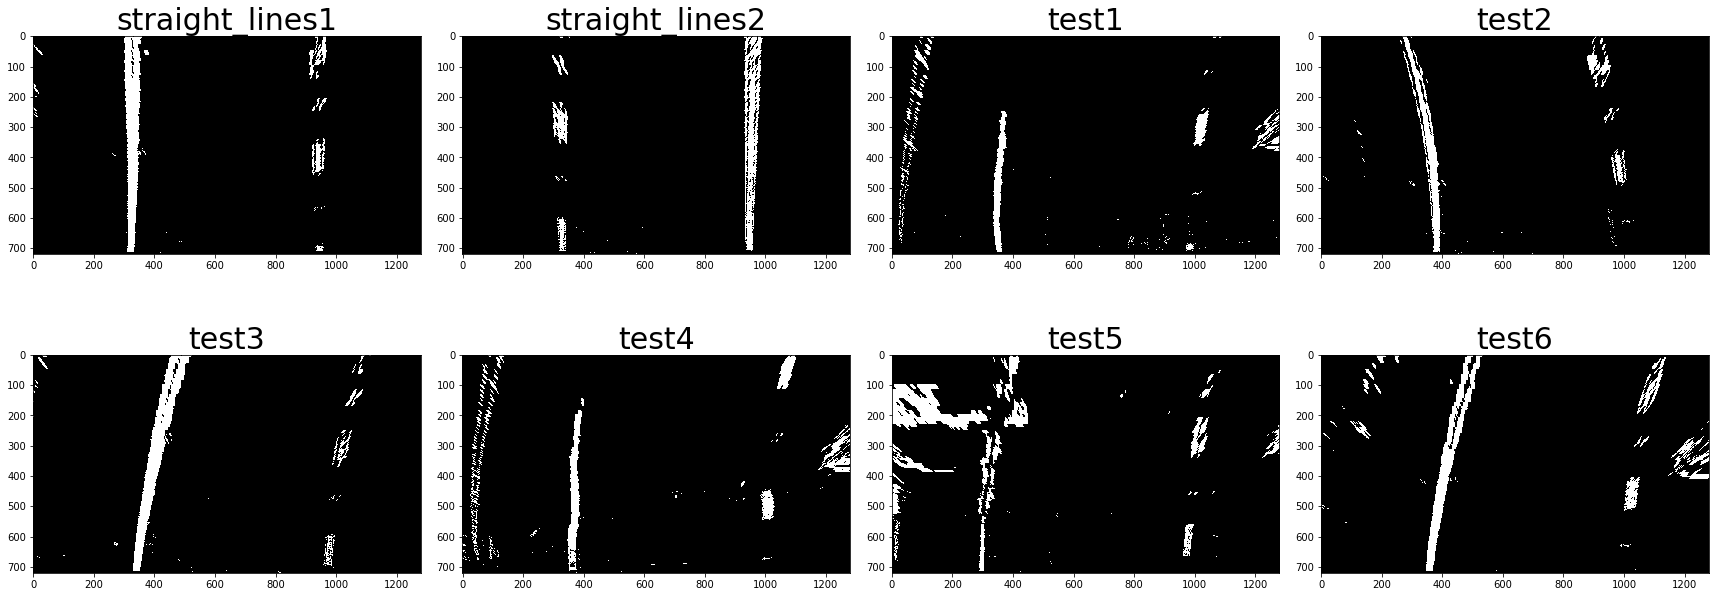

In [32]:
# Test function
f, arr = plt.subplots(2,4, figsize=(24, 9))
f.tight_layout()
for i in range(len(images)):
    _, warped_i, _, _ = warp_camera(images[i])
    r = i//4  # row of image 
    c = i - r*4  # colomn of image
    arr[r,c].imshow(warped_i, cmap='gray')
    arr[r,c].set_title(names[i], fontsize=30)
plt.savefig('./output_images/warped_binary_image.jpg')


# 5. Decide Which Pixels Are Lane Line Pixels

Detect lane pixels and fit to find the lane boundary

## 5.1 Window Fitting

In [33]:
def window_mask(width, height, img_ref, center,level):
    """
    The function is used to draw window areas.
    """
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

In [34]:
def find_window_centroids(binary_warped, window_width, window_height, margin):
    """
    The function finds all the left and right window centroids 
    for each level in the given binary image.
    """
    window_centroids = [] # Store the (left, right) window centroid positions per level
    window = np.ones(window_width) # Create out window template that we will use for convolutions
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(binary_warped[int(3*binary_warped.shape[0]/4):,:int(binary_warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    
    r_sum = np.sum(binary_warped[int(3*binary_warped.shape[0]/4):,int(binary_warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(binary_warped.shape[1]/2)

    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,int(binary_warped.shape[0]/window_height)):
        # Convolve the window into the vertical slice of the image
        layer_bottom = int(binary_warped.shape[0]-(level+1)*window_height)
        layer_top = int(binary_warped.shape[0]-level*window_height)
        image_layer = np.sum(binary_warped[layer_bottom:layer_top, :], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        # Find the best left centroid by using past left center as a reference
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,binary_warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,binary_warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
        
    return window_centroids

In [35]:
def mark_centroids(binary_warped, window_width, window_height, margin):
    """
    The function find and mark left and right centroids.
    """
    window_centroids = find_window_centroids(binary_warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(binary_warped)
        r_points = np.zeros_like(binary_warped)

        # Go through each level and draw the windows
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found
            l_points[(l_points == 255) | ((l_mask == 1))] = 255
            r_points[(r_points == 255) | ((r_mask == 1))] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green 
        warpage = np.dstack((binary_warped, binary_warped, binary_warped))*255 # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the original road image with window results 

    # If no window centers found, just display original road image 
    else:
        output = np.array(cv2.merge((binary_warped, binary_warped, binary_warped)),np.uint8)
    
    return output

In [36]:
# Window settings
window_width = 50
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 50 # How much to slide left and right for searching

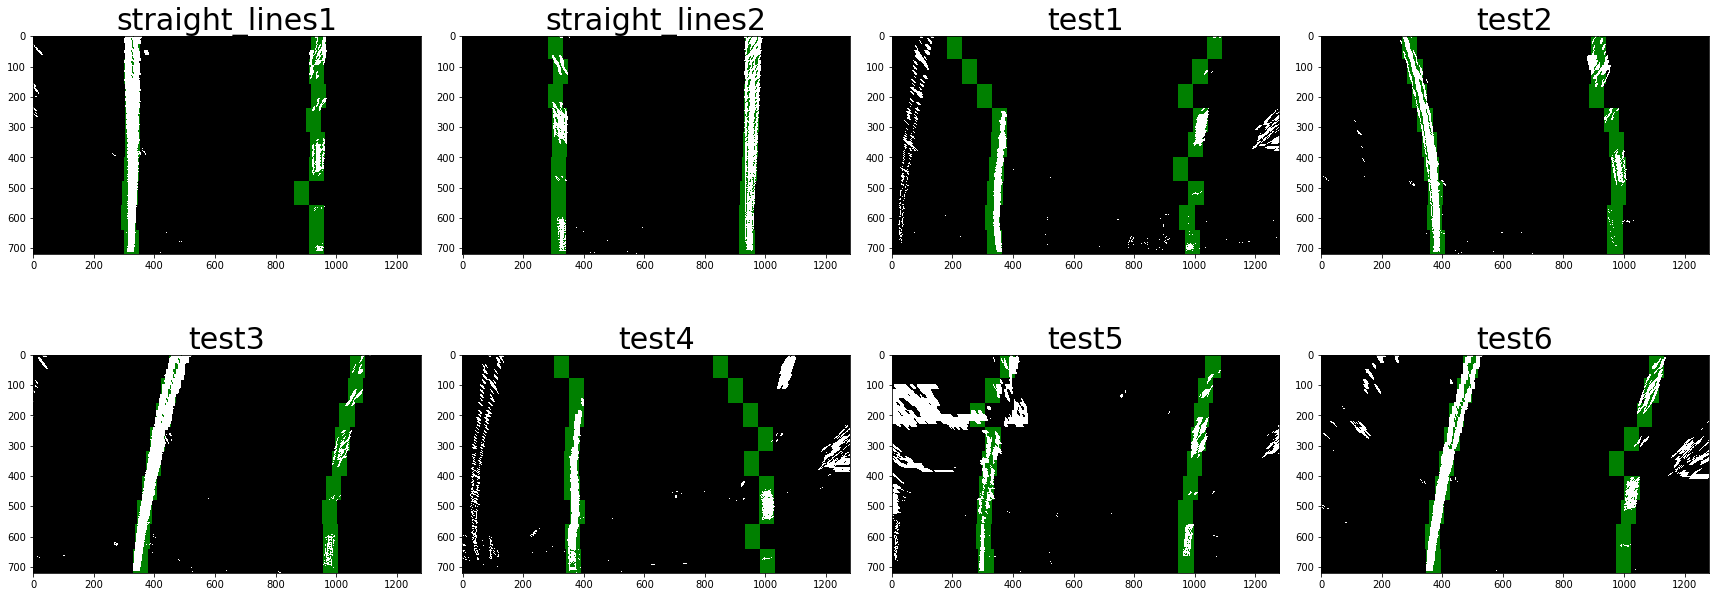

In [37]:
f, arr = plt.subplots(2,4, figsize=(24, 9))
f.tight_layout()
for i in range(len(images)):
    _, warped_i, _, _ = warp_camera(images[i])
    mark_centroids_i = mark_centroids(warped_i, window_width, window_height, margin)
    r = i//4  # row of image 
    c = i - r*4  # colomn of image
    arr[r,c].imshow(mark_centroids_i, cmap='gray')
    arr[r,c].set_title(names[i], fontsize=30)
plt.savefig('./output_images/window_fitting_result.jpg')

## 5.2 Find and Plot a Track Line 

In [38]:
def find_ploty(binary_warped, window_centroids, window_height, window_width):
    """
    The function extract left and right line pixel positions
    to fit a second order polynomial to both, and generate x and y for plotting.
    """
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Set minimum number of pixels found to recenter window
    minpix = 100
    # Create empty lists to receive valid left and right lane point coordinates
    leftx = []
    lefty = []
    rightx = []
    righty = []

    # Go through each level to find
    for level in range(0, len(window_centroids)):

        # Identify window areas
        l_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][1],level)
        l_mask = np.array(l_mask)
        r_mask = np.array(r_mask)
        # Identify the nonzero pixels in x and y within the window
        good_left = (binary_warped*l_mask).nonzero()
        good_right = (binary_warped*r_mask).nonzero()
        # Append these coordinates to the lists
        lefty.append(good_left[0])
        leftx.append(good_left[1])
        righty.append(good_right[0])
        rightx.append(good_right[1])
    
    # Concatenate the arrays of nonzero pixel coordinates
    lefty = np.concatenate(lefty)
    leftx = np.concatenate(leftx)
    righty = np.concatenate(righty)
    rightx = np.concatenate(rightx)

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Pack all x and y coordinates to cut down the numbers of output
    lane = np.array([lefty, leftx, righty, rightx])
    fitx = np.array([left_fitx, right_fitx])
    
    return ploty, lane, fitx

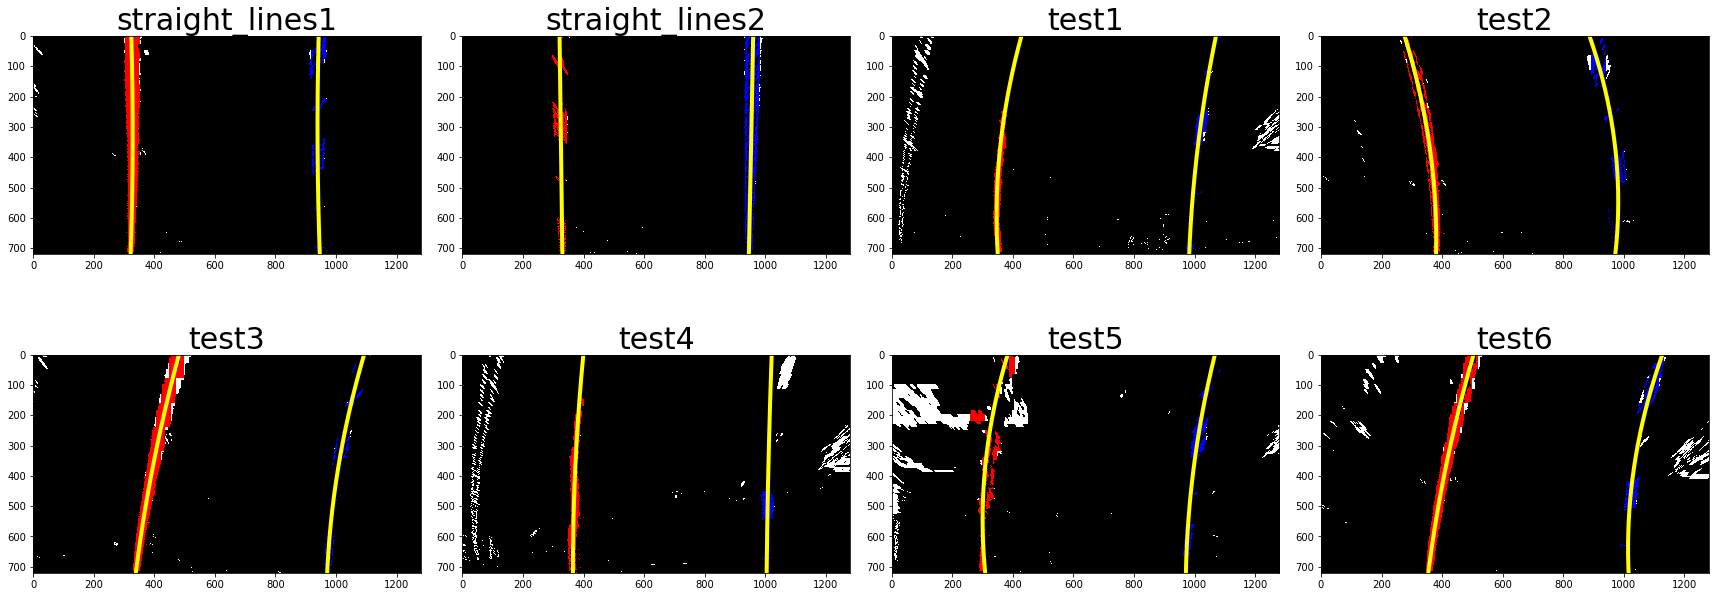

In [39]:
f, arr = plt.subplots(2,4, figsize=(24, 9))
f.tight_layout()
for i in range(len(images)):
    _, warped_i, _, _ = warp_camera(images[i])
    window_centroids_i = find_window_centroids(warped_i, window_width, window_height, margin)
    ploty_i, lane_i, fitx_i = find_ploty(warped_i, window_centroids_i, window_height, window_width)
    r = i//4  # row of image 
    c = i - r*4  # colomn of image
    # Create an output image to draw on and visualize the result 
    out_img_i = np.dstack((warped_i, warped_i, warped_i))*255
    out_img_i[lane_i[0], lane_i[1]] = [255, 0, 0]
    out_img_i[lane_i[2], lane_i[3]] = [0, 0, 255]
    # Draw Lane Lines
    arr[r,c].imshow(out_img_i, cmap='gray', extent=(0,1280,720,0))
    arr[r,c].plot(fitx_i[0], ploty_i, color='yellow', linewidth=4)
    arr[r,c].plot(fitx_i[1], ploty_i, color='yellow', linewidth=4)
    arr[r,c].set_title(names[i], fontsize=30)
plt.savefig('./output_images/find_ploty.jpg')

# 6. Determine the Line Shape and Position

Determine the curvature of the lane and vehicle position with respect to center.

## 6.1 Measuring Curvature

In [40]:
def measure_curve(ploty, fitx):
    """
    The function calculates the radius of curcature after correcting
    for scale in x and y.
    """
    # Define y-value where we want radius of curvature
    # Here I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters.
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, fitx[0]*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, fitx[1]*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1]**2)**1.5) / np.absolute(2*right_fit_cr[0]))
    
    return left_curverad, right_curverad

In [41]:
# Test function
for i in range(len(images)):
    undistorted_i, warp_i, M_i, Minv_i = warp_camera(images[i])
    window_centroids_i = find_window_centroids(warp_i, window_width, window_height, margin)
    ploty_i, lane_i, fitx_i = find_ploty(warp_i, window_centroids_i, window_height, window_width)
    left_curverad_i, right_curverad_i = measure_curve(ploty_i, fitx_i)
    
    print('['+ names[i] +']')
    print('R_left = {:0.2f}(m), R_right = {:0.2f}(m)'.format(left_curverad_i, right_curverad_i))
    
    # Take the average of the left and right curve rad as the lane curveture
    if np.isfinite(right_curverad_i)==False:
        right_curverad_i = left_curverad_i
    if np.isfinite(left_curverad_i)==False:
        left_curverad_i = right_curverad_i
    curvature_i = (left_curverad_i + right_curverad_i)/2
    
    print('Radius of Curvature = {:0.2f}(m)'.format(curvature_i))

[straight_lines1]
R_left = 3741.42(m), R_right = 3851.54(m)
Radius of Curvature = 3796.48(m)


/Users/yanran/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


[straight_lines2]
R_left = 210573.06(m), R_right = nan(m)
Radius of Curvature = 210573.06(m)
[test1]
R_left = 707.45(m), R_right = 1420.46(m)
Radius of Curvature = 1063.96(m)
[test2]
R_left = 709.11(m), R_right = nan(m)
Radius of Curvature = 709.11(m)
[test3]
R_left = 1625.19(m), R_right = 960.96(m)
Radius of Curvature = 1293.07(m)
[test4]
R_left = 2424.32(m), R_right = 9230.60(m)
Radius of Curvature = 5827.46(m)
[test5]
R_left = 590.13(m), R_right = 1051.76(m)
Radius of Curvature = 820.94(m)
[test6]
R_left = 1443.10(m), R_right = 599.76(m)
Radius of Curvature = 1021.43(m)


## 6.2 Determine Vehicle Position

In [42]:
def car_position(lane, road_center):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    road_center = road_center * xm_per_pix
    
    # Take the bottom x positions of the left and right lanes
    x_left = lane[1][0] * xm_per_pix
    x_right = lane[3][0] * xm_per_pix
    x_mean = (x_left + x_right)/2
    position = road_center - x_mean
    
    return position

In [43]:
road_center = img_lane.shape[1]/2
road_center

640.0

In [44]:
for i in range(len(images)):
    undistorted_i, warp_i, M_i, Minv_i = warp_camera(images[i])
    window_centroids_i = find_window_centroids(warp_i, window_width, window_height, margin)
    ploty_i, lane_i, fitx_i = find_ploty(warp_i, window_centroids_i, window_height, window_width)
    position_i = car_position(lane_i, road_center)
    
    print('['+ names[i] +']')
    if position_i > 0:
        print('Vehicle is {:0.2f}m left of center'.format(position_i))
    elif position_i < 0:
        print('Vehicle is {:0.2f}m right of center'.format(-position_i))
    else:
        print('Vehicle is on the center')

[straight_lines1]
Vehicle is 0.06m left of center
[straight_lines2]
Vehicle is 0.08m left of center
[test1]
Vehicle is 0.13m right of center
[test2]
Vehicle is 0.14m right of center
[test3]
Vehicle is 0.05m right of center
[test4]
Vehicle is 0.22m right of center
[test5]
Vehicle is 0.06m left of center
[test6]
Vehicle is 0.19m right of center


## 6.3 Drawing Lane

In [45]:
def drawing(undistorted_image, binary_warped, ploty, fitx, Minv):
    """
    The funtion draw the area between detected lane lines on the undistorted original image.
    """
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([fitx[0], ploty]))]) 
    pts_right = np.array([np.flipud(np.transpose(np.vstack([fitx[1], ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))
    
    # Warp the blank back to original image space using inversed perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_image.shape[1], undistorted_image.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_image, 1, newwarp, 0.3, 0)
    
    return result

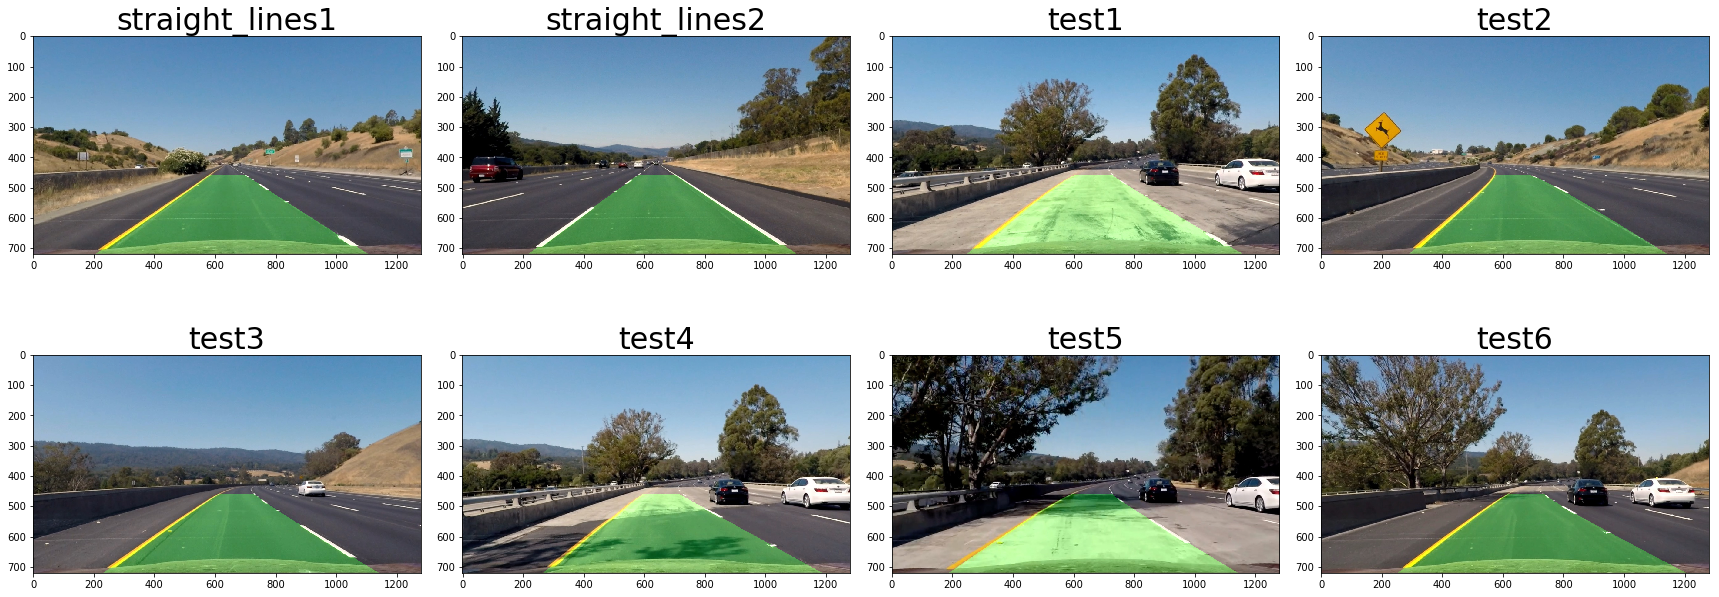

In [46]:
# Test function
f, arr = plt.subplots(2,4, figsize=(24, 9))
f.tight_layout()
for i in range(len(images)):
    undistorted_i, warp_i, M_i, Minv_i = warp_camera(images[i])
    window_centroids_i = find_window_centroids(warp_i, window_width, window_height, margin)
    ploty_i, lane_i, fitx_i = find_ploty(warp_i, window_centroids_i, window_height, window_width)
    result_i = drawing(undistorted_i, warp_i, ploty_i, fitx_i, Minv_i)
    r = i//4  # row of image 
    c = i - r*4  # colomn of image
    arr[r,c].imshow(result_i, cmap='gray')
    arr[r,c].set_title(names[i], fontsize=30)
plt.savefig('./output_images/draw_lane_area.jpg')

In [47]:
def drawing_lane(undistorted_image, binary_warped, lane, Minv):
    """
    The funtion draw the detected left and right lane lines on the undistorted original image
    in red and blue respectively.
    """
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # draw red left and blue right lane lines
    color_warp[lane[0], lane[1]] = [0, 255, 255]
    color_warp[lane[2], lane[3]] = [255, 255, 0]
    
    # Warp the blank back to original image space using inversed perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_image.shape[1], undistorted_image.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_image, 1, newwarp, -0.7, 0)
    
    return result

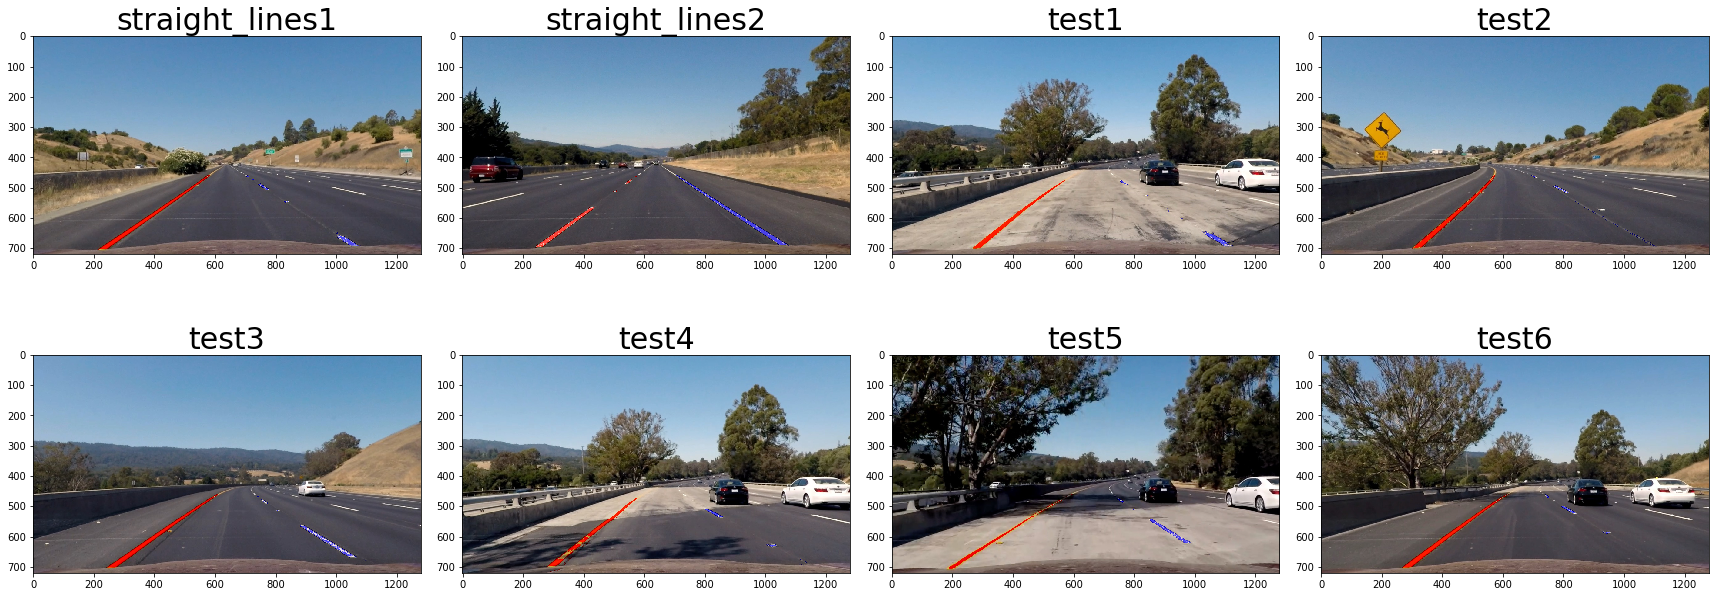

In [48]:
# Test function
f, arr = plt.subplots(2,4, figsize=(24, 9))
f.tight_layout()
for i in range(len(images)):
    undistorted_i, warp_i, M_i, Minv_i = warp_camera(images[i])
    window_centroids_i = find_window_centroids(warp_i, window_width, window_height, margin)
    ploty_i, lane_i, fitx_i = find_ploty(warp_i, window_centroids_i, window_height, window_width)
    result_i = drawing_lane(undistorted_i, warp_i, lane_i, Minv_i)
    r = i//4  # row of image 
    c = i - r*4  # colomn of image
    arr[r,c].imshow(result_i, cmap='gray')
    arr[r,c].set_title(names[i], fontsize=30)
plt.savefig('./output_images/draw_lane_line.jpg')

# 7. Output

Warp the detected lane boundaries back onto the original image.

Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## 7.1 Define Function to Process Image


In [49]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [50]:
def process_image(img_camera):
    '''
    The function:
    1. undistorts the original camera image,
    2. converts the undistorted image into a binary form via 
    applying color & gradient thresholds,
    3. warps the binary image into birds-eye perspective,
    4. detects lane curvature and position via the warped binary image,
    5. displays the curvature and position on the undistorted image,
    6. draws/marks the detected lane on the undistorted image.
    '''
    
    # Undistort the original image to draw lane lines on it later
    # Apply color&gradient thresholds and birds-eye perspective on the undistorted image
    undistorted_image, binary_warped, M, Minv = warp_camera(img_camera)
    # Detect the left and right lane lines
    window_centroids = find_window_centroids(binary_warped, window_width=50, window_height=80, margin=40)
    ploty, lane, fitx = find_ploty(binary_warped, window_centroids, window_height=80, window_width=50)
    
    # Detect lane curvature and position
    left_curverad, right_curverad = measure_curve(ploty, fitx)
    curvature = (left_curverad + right_curverad)/2
    position = car_position(lane, 640)
    
    # Display lane curvature and position on the undistorted image
    font = cv2.FONT_HERSHEY_SIMPLEX
    T_rad = 'Radius of Curvature = {:0.2f}(m)'.format(curvature)
    if position > 0:
        T_position = 'Vehicle is {:0.2f}m left of center'.format(position)
    elif position < 0:
        T_position = 'Vehicle is {:0.2f}m right of center'.format(-position)
    else:
        T_position = 'Vehicle is on the center'

    cv2.putText(undistorted_image, T_rad,(60,100), font, 1.5,(255,255,255), 3, cv2.LINE_AA)
    cv2.putText(undistorted_image, T_position,(60,150), font, 1.5,(255,255,255), 3, cv2.LINE_AA)
    
    # Drawing
    result = drawing_lane(undistorted_image, binary_warped, lane, Minv)
    result = drawing(result, binary_warped, ploty, fitx, Minv)
    
    return result

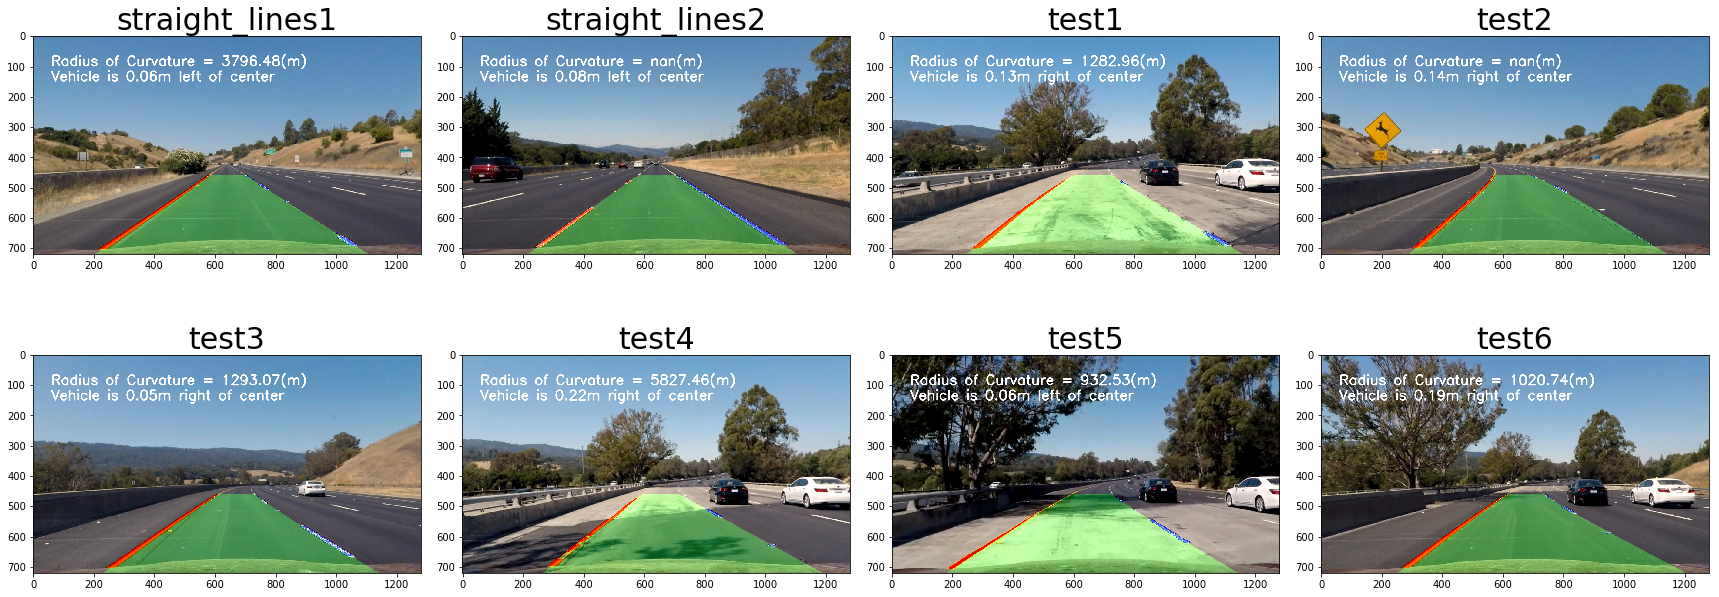

In [51]:
# Test function
f, arr = plt.subplots(2,4, figsize=(24, 9))
f.tight_layout()
for i in range(len(images)):
    result_i = process_image(images[i])
    r = i//4  # row of image 
    c = i - r*4  # colomn of image
    arr[r,c].imshow(result_i, cmap='gray')
    arr[r,c].set_title(names[i], fontsize=30)
plt.savefig('./output_images/process_image.jpg')

## 7.2 Project Video

In [52]:
white_output1 = './test_videos_output/project_video.mp4'

# You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("./project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("./project_video.mp4")
white_clip1 = clip1.fl_image(process_image)
%time white_clip1.write_videofile(white_output1, audio=False)

[MoviePy] >>>> Building video ./test_videos_output/project_video.mp4
[MoviePy] Writing video ./test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [24:30<00:01,  1.15s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_videos_output/project_video.mp4 

CPU times: user 25min 22s, sys: 1min 22s, total: 26min 45s
Wall time: 24min 32s


In [53]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(white_output1))

## 7.3 Challenge Video

In [54]:
white_output2 = './test_videos_output/challenge_video.mp4'

# You may also uncomment the following line for a subclip of the first 5 seconds
clip2 = VideoFileClip("./challenge_video.mp4").subclip(0,5)
#clip2 = VideoFileClip("./challenge_video.mp4")
white_clip2 = clip2.fl_image(process_image)
%time white_clip2.write_videofile(white_output2, audio=False)

[MoviePy] >>>> Building video ./test_videos_output/challenge_video.mp4
[MoviePy] Writing video ./test_videos_output/challenge_video.mp4


100%|██████████| 150/150 [02:54<00:00,  1.17s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_videos_output/challenge_video.mp4 

CPU times: user 3min, sys: 9.75 s, total: 3min 10s
Wall time: 2min 56s


In [55]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(white_output2))

## 7.3 Harder Challenge Video

In [56]:
white_output3 = './test_videos_output/harder_challenge_video.mp4'

# You may also uncomment the following line for a subclip of the first 5 seconds
clip3 = VideoFileClip("./harder_challenge_video.mp4").subclip(0,5)
#clip3 = VideoFileClip("./harder_challenge_video.mp4")
white_clip3 = clip3.fl_image(process_image)
%time white_clip3.write_videofile(white_output3, audio=False)

[MoviePy] >>>> Building video ./test_videos_output/harder_challenge_video.mp4
[MoviePy] Writing video ./test_videos_output/harder_challenge_video.mp4


 99%|█████████▉| 125/126 [02:30<00:01,  1.21s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_videos_output/harder_challenge_video.mp4 

CPU times: user 2min 36s, sys: 8.33 s, total: 2min 44s
Wall time: 2min 33s


In [57]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(white_output3))